In [1]:
import xmltodict
from urllib.request import urlopen
import xml.etree.ElementTree as ET
import pandas as pd

from dateutil.parser import parse

import matplotlib.pyplot as plt
from IPython.display import display 

plt.style.use('seaborn-paper')
%matplotlib inline

# Hansard - OralQuestionPeriod

In [6]:
def xml2df(xml_data):
#     print(xml_data)
    root = ET.XML(xml_data) # element tree

    all_records = [] #This is our record list which we will convert into a dataframe
    
    orderOfBusinessList = root.find('HansardBody').iter('OrderOfBusiness')
    
    volume = root.findall(".//ExtractedItem[@Name='Volume']")[0].text
    number = root.findall(".//ExtractedItem[@Name='Number']")[0].text
    session = root.findall(".//ExtractedItem[@Name='Session']")[0].text
    parliament = root.findall(".//ExtractedItem[@Name='Parliament']")[0].text
    speakerName = root.findall(".//ExtractedItem[@Name='SpeakerName']")[0].text
    date = root.findall(".//ExtractedItem[@Name='Date']")[0].text   
#     print(volume)
    
    for orderOfBusiness in orderOfBusinessList:
        
        orderOfBusinessRubric = orderOfBusiness.attrib['Rubric']
#         print('orderOfBusinessRubric', orderOfBusinessRubric)
        if (orderOfBusinessRubric == 'OralQuestionPeriod'):
        
            orderOfBusinessId =  orderOfBusiness.attrib['id']            
            orderOfBusinessCatchLine = orderOfBusiness.find('CatchLine').text
        
            for subjectOfBusiness in orderOfBusiness.findall('SubjectOfBusiness'):

                subjectOfBusinessContent = subjectOfBusiness.find('SubjectOfBusinessContent')
                for intervention in subjectOfBusinessContent.iter('Intervention'):
                    
                    record = {} #Place holder for our record
                    record['orderOfBusinessId'] = orderOfBusinessId
                    record['orderOfBusinessRubric'] = orderOfBusinessRubric
                    record['orderOfBusinessCatchLine'] = orderOfBusinessCatchLine
                    record['volume'] = volume
                    record['number'] = number        
                    record['session'] = session
                    record['parliament'] = parliament
                    record['speakerName'] = speakerName
                    record['date'] = date
                                            
                    try:
                        record['subjectOfBusinessId'] = subjectOfBusiness.attrib['id']
                    except Exception:
                        continue    
                        
                    try:
                        record['SubjectOfBusinessTitle'] = subjectOfBusiness.find('SubjectOfBusinessTitle').text.strip()
                    except Exception:
                        record['SubjectOfBusinessTitle'] = 'generic'
                        

                    try:
                        record['FloorLanguage'] = subjectOfBusiness.find('FloorLanguage').attrib['language']
                    except Exception:
                        record['FloorLanguage'] = 'EN'

                    record['personSpeaking'] = intervention.findall('PersonSpeaking/Affiliation')[0].text
                    record['personId'] =intervention.findall('PersonSpeaking/Affiliation')[0].attrib['DbId']
                    
                    # Get all texts from intervention - Only one person is speaking per intervention.
#                     content = []
                    
                    content = ET.tostring(intervention.find('Content'), encoding='UTF-8', method='text')
                    record['content'] = content.decode('UTF-8')
#                     for paraText in intervention.iter('ParaText'):
#                         if paraText.text is not None:
#                             content.append(paraText.text)

#                     record['content'] = ' \lineBreak '.join(content)
                    
                    all_records.append(record) #Append this record to all_records. 

    return pd.DataFrame(all_records) #return records as DataFrame



In [7]:
link = 'http://www.ourcommons.ca/Content/House/{parliamentSession}/Debates/{session}/HAN{session}-E.XML'
# link = 'http://www.ourcommons.ca/Content/House/412/Debates/{session}/HAN{session}-E.XML'

link_list = []
session = 10
# session = 236
# session = 264
parliament_session  = {'421' : 276,
                       '412' : 235,
                       '411': 272
                      }

# parliament_session  = {'421' : 10,
#                        '412' : 10,
#                        '411': 210}

for parliament, session  in parliament_session.items():
    print(parliament, session)
    for i in range (1, session + 1):
        temp = link.replace('{parliamentSession}', parliament)
        temp = temp.replace('{session}', '{:03}'.format(i))
#         print(temp)
        link_list.append(temp)

print('link_list', len(link_list))
print(link_list[0])

421 276
412 235
411 272
link_list 783
http://www.ourcommons.ca/Content/House/421/Debates/001/HAN001-E.XML


In [8]:
from joblib import Parallel, delayed
import multiprocessing
    
df_list = []
def processLink(link):
    print('processing', link)
    urlContent = urlopen(link)
    xml = urlContent.read()
    return xml2df(xml)

num_cores = multiprocessing.cpu_count()
print(num_cores)
    
results = Parallel(n_jobs=num_cores)(delayed(processLink)(i) for i in link_list)



8
processing http://www.ourcommons.ca/Content/House/421/Debates/005/HAN005-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/006/HAN006-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/007/HAN007-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/008/HAN008-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/003/HAN003-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/002/HAN002-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/004/HAN004-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/001/HAN001-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/009/HAN009-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/010/HAN010-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/011/HAN011-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/012/HAN012-E.XML
processing http://www.ourcommons.ca/Content/House/

processing http://www.ourcommons.ca/Content/House/421/Debates/104/HAN104-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/106/HAN106-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/108/HAN108-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/112/HAN112-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/110/HAN110-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/113/HAN113-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/114/HAN114-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/100/HAN100-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/115/HAN115-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/102/HAN102-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/116/HAN116-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/117/HAN117-E.XML
processing http://www.ourcommons.ca/Content/House/42

processing http://www.ourcommons.ca/Content/House/421/Debates/209/HAN209-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/210/HAN210-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/211/HAN211-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/212/HAN212-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/213/HAN213-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/214/HAN214-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/215/HAN215-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/216/HAN216-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/217/HAN217-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/218/HAN218-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/219/HAN219-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/220/HAN220-E.XML
processing http://www.ourcommons.ca/Content/House/42

processing http://www.ourcommons.ca/Content/House/412/Debates/037/HAN037-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/038/HAN038-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/039/HAN039-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/040/HAN040-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/041/HAN041-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/042/HAN042-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/043/HAN043-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/044/HAN044-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/045/HAN045-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/046/HAN046-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/047/HAN047-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/048/HAN048-E.XML
processing http://www.ourcommons.ca/Content/House/41

processing http://www.ourcommons.ca/Content/House/412/Debates/141/HAN141-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/142/HAN142-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/143/HAN143-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/144/HAN144-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/145/HAN145-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/146/HAN146-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/147/HAN147-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/148/HAN148-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/149/HAN149-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/150/HAN150-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/151/HAN151-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/152/HAN152-E.XML
processing http://www.ourcommons.ca/Content/House/41

processing http://www.ourcommons.ca/Content/House/411/Debates/010/HAN010-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/011/HAN011-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/012/HAN012-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/013/HAN013-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/014/HAN014-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/015/HAN015-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/016/HAN016-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/017/HAN017-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/018/HAN018-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/019/HAN019-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/020/HAN020-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/021/HAN021-E.XML
processing http://www.ourcommons.ca/Content/House/41

processing http://www.ourcommons.ca/Content/House/411/Debates/114/HAN114-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/115/HAN115-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/116/HAN116-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/117/HAN117-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/118/HAN118-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/119/HAN119-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/120/HAN120-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/121/HAN121-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/122/HAN122-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/123/HAN123-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/124/HAN124-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/125/HAN125-E.XML
processing http://www.ourcommons.ca/Content/House/41

processing http://www.ourcommons.ca/Content/House/411/Debates/218/HAN218-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/219/HAN219-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/220/HAN220-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/221/HAN221-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/222/HAN222-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/223/HAN223-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/224/HAN224-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/225/HAN225-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/226/HAN226-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/227/HAN227-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/228/HAN228-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/229/HAN229-E.XML
processing http://www.ourcommons.ca/Content/House/41

In [10]:
# results[0]

df_hansard = pd.concat(results)
df_hansard.reset_index(inplace=True)

df_hansard['date'] =  pd.to_datetime(df_hansard['date'])

df_hansard.to_csv('data/hansard_all.csv')
df_hansard.tail()

,index,FloorLanguage,SubjectOfBusinessTitle,content,date,number,orderOfBusinessCatchLine,orderOfBusinessId,orderOfBusinessRubric,parliament,personId,personSpeaking,session,speakerName,subjectOfBusinessId,volume
70668,80,EN,Employment,"Mr. Speaker, our government has introduced ref...",2013-06-18,NUMBER 272,Oral Questions,8090062,OralQuestionPeriod,41st PARLIAMENT,170869,Ms. Kellie Leitch (Parliamentary Secretary to ...,1st SESSION,Speaker: The Honourable Andrew Scheer,8090323,VOLUME 146
70669,81,EN,Points of Order,"Mr. Speaker, I raised this point of order some...",2013-06-18,NUMBER 272,Oral Questions,8090062,OralQuestionPeriod,41st PARLIAMENT,170542,"Ms. Elizabeth May (Saanich—Gulf Islands, GP)",1st SESSION,Speaker: The Honourable Andrew Scheer,8090331,VOLUME 146
70670,82,EN,Points of Order,I thank the hon. member for Saanich—Gulf Islan...,2013-06-18,NUMBER 272,Oral Questions,8090062,OralQuestionPeriod,41st PARLIAMENT,170958,The Speaker,1st SESSION,Speaker: The Honourable Andrew Scheer,8090331,VOLUME 146
70671,83,EN,Points of Order,"Mr. Speaker, I heard the comment from the memb...",2013-06-18,NUMBER 272,Oral Questions,8090062,OralQuestionPeriod,41st PARLIAMENT,170302,"Mr. Daryl Kramp (Prince Edward—Hastings, CPC)",1st SESSION,Speaker: The Honourable Andrew Scheer,8090331,VOLUME 146
70672,84,EN,Points of Order,We are certainly not going to get into debate ...,2013-06-18,NUMBER 272,Oral Questions,8090062,OralQuestionPeriod,41st PARLIAMENT,170958,The Speaker,1st SESSION,Speaker: The Honourable Andrew Scheer,8090331,VOLUME 146


In [11]:
df_hansard['content'][0]

'Mr. Speaker, last night, President Obama stated that air strikes were a key pillar in the fight against ISIS. In the last week, we have seen the Obama administration, Germany, France, and the U.K. step up their efforts in their air strikes. Meanwhile, the Prime Minister has ordered our CF-18s to stand down. Why is the Prime Minister stepping back from the fight when our allies are stepping up?'

Ethics                                   7078
National Defence                         3771
Taxation                                 3057
The Environment                          2780
Public Safety                            2191
Foreign Affairs                          2135
Employment                               1990
Health                                   1701
Democratic Reform                        1675
Aboriginal Affairs                       1566
Employment Insurance                     1540
International Trade                      1525
Veterans Affairs                         1378
Justice                                  1366
Natural Resources                        1352
Infrastructure                           1348
The Economy                              1311
Citizenship and Immigration              1147
Points of Order                           985
generic                                   919
Indigenous Affairs                        885
Pensions                          

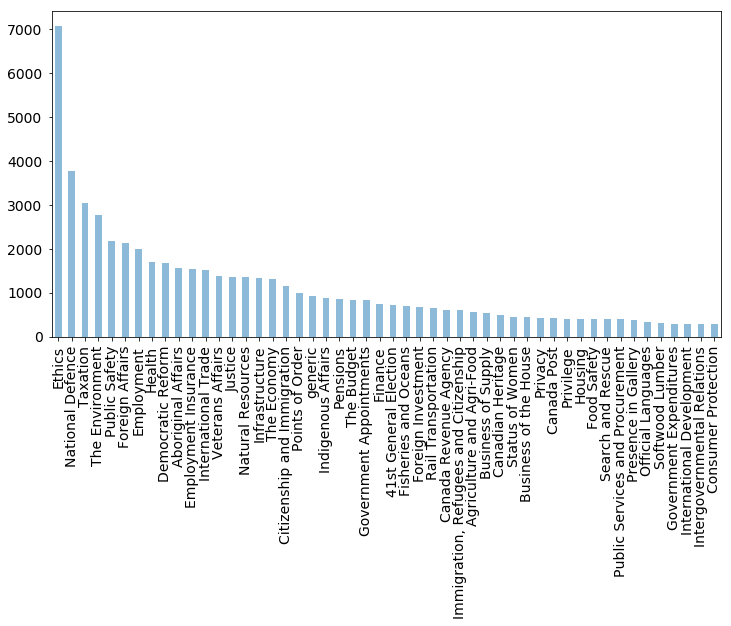

In [12]:
print(df_hansard['SubjectOfBusinessTitle'].value_counts()[:50])

df_hansard['SubjectOfBusinessTitle'].value_counts()[:50].plot(kind='bar', alpha=.5, figsize=(12,6), fontsize=14)

In [ ]:
# https://www.ourcommons.ca/en/open-data#ChamberDebates
link =  'http://www.ourcommons.ca/Content/House/{ParliamentSession}/Debates/{SittingNumber}/HAN{SittingNumber}-E.XML'

# https://www.ourcommons.ca/Content/House/421/Debates/251/HAN251-E.XML
    
link = link.replace('{ParliamentSession}', '421')
link = link.replace('{SittingNumber}', '251')
link = link.replace('{SittingNumber}', '251')

print(link)


def xml2df(xml_data):
#     print(xml_data)
    root = ET.XML(xml_data) # element tree

    all_records = [] #This is our record list which we will convert into a dataframe
    
    orderOfBusinessList = root.find('HansardBody').iter('OrderOfBusiness')
    
    
    for orderOfBusiness in orderOfBusinessList:
        
#         print(orderOfBusiness.find('CatchLine'))
        orderOfBusinessId =  orderOfBusiness.attrib['id']
        orderOfBusinessRubric = orderOfBusiness.attrib['Rubric']
        orderOfBusinessCatchLine = orderOfBusiness.find('CatchLine').text
#         orderOfBusinessFloorLanguage = orderOfBusiness.find('SubjectOfBusiness')
        
#         record['timestamp'] = parse( publicationItem.attrib['Date'])
#         record['speakerId'] = publicationItem.find('Person').attrib['Id']
        paragraphs = []
        for subjectOfBusiness in orderOfBusiness.findall('SubjectOfBusiness'):
            record = {} #Place holder for our record
#             print(subjectOfBusiness.attrib)
            try:
                record['subjectOfBusinessId'] = subjectOfBusiness.attrib['id']
            except Exception:
                continue
                
            record['orderOfBusinessId'] = orderOfBusinessId
            record['orderOfBusinessRubric'] = orderOfBusinessRubric
            record['orderOfBusinessCatchLine'] = orderOfBusinessCatchLine
            
            if subjectOfBusiness.find('SubjectOfBusinessTitle') is not None:
                record['SubjectOfBusinessTitle'] = subjectOfBusiness.find('SubjectOfBusinessTitle').text
            else:
                record['SubjectOfBusinessTitle'] = 'generic'
            
            if subjectOfBusiness.find('FloorLanguage') is not None:
                record['FloorLanguage'] = subjectOfBusiness.find('FloorLanguage').attrib['language']
            else:
                record['FloorLanguage'] = 'EN'
               
#           print(subjectOfBusiness.findall("Intervention/PersonSpeaking/Affiliation"))
            # SpeakerId
#             if subjectOfBusiness.findall("./Intervention/PersonSpeaking/Affiliation") is not None:
#                 record['speakerId'] = subjectOfBusiness.findall("./Intervention/PersonSpeaking/Affiliation")[0].attrib['DbId']
#             else:
#                 record['speakerId'] = '1' # generic
                
                
                
            subjectOfBusinessContent = subjectOfBusiness.find('SubjectOfBusinessContent')
            
#             print(subjectOfBusinessContent.iter('ParaText'))
            content = []
            
            for paraText in subjectOfBusinessContent.iter('ParaText'):
                content.append(paraText.text)
                
            record['content'] = content
            
            all_records.append(record) #Append this record to all_records. 
            
#         record['paragText'] = paragraphs        
#         break
    
    df = pd.DataFrame(all_records)
    df.set_index(df['subjectOfBusinessId'])
    return df #return records as DataFrame

# Id	paragText	speakerId	timestamp

urlContent = urlopen(link)
xml = urlContent.read()
df = xml2df(xml)

# df['content'][2]

df.head()
# df.tail()
# df.info()





In [ ]:
# for row in df['content'].values:
#     print(row)

# df

In [ ]:

link = 'http://www.ourcommons.ca/Parliamentarians/en/PublicationSearch?View=D&Item=&ParlSes=42-1&oob=&Topic=&Per=&Prov=&Cauc=&Text=&RPP=15&order=&targetLang=&SBS=0&MRR=150000&PubType=37&xml=1'
#        'http://www.ourcommons.ca/Parliamentarians/en/PublicationSearch?View=L&Item=&ParlSes=42-1&Topic=38047&com=&Per=&Prov=&Cauc=&PartType=&Text=&RPP=15&order=&targetLang=&SBS=0&MRR=2000000&PubType=40017&xml=1'
urlContent = urlopen(link)
xml = urlContent.read()
print(xml)

In [ ]:
# print(len(doc['Results']))

# print(doc['Results']['Publications']['Publication'][0]['PublicationItems']['PublicationItem'][0]
#       ['XmlContent']['Intervention']['Content']['ParaText'][1])



# <PublicationItem Id="9326459" EventId="9885804" 
# VideoURL="" Sequence="5" Page="16240" PdfPage="4" 
# TypeId="38" Date="2017-12-11" Hour="11" Minute="12" Second="20" 
# FacebookLink="?PubType=37&Item=9326459" TwitterLink="">
from datetime import datetime




def xml2df(xml_data):
#     print(xml_data)
    root = ET.XML(xml_data) # element tree

    all_records = [] #This is our record list which we will convert into a dataframe
    
    for publicationItem in root.iter('PublicationItem'):
        record = {} #Place holder for our record
        record['Id'] =  publicationItem.attrib['Id']
        record['timestamp'] = parse( publicationItem.attrib['Date'])
        record['speakerId'] = publicationItem.find('Person').attrib['Id']
        paragraphs = []
        for paratext in publicationItem.find('XmlContent').iter('ParaText'):
            paragraphs.append(paratext.text)
            
        record['paragText'] = paragraphs

        
    
        all_records.append(record) #Append this record to all_records. 
#         break
    
    df = pd.DataFrame(all_records)
    df.set_index(df['Id'])
    return df #return records as DataFrame

# print(urlContent.read())
df = xml2df(xml)

df.to_csv('results.csv' , sep='\t', encoding='utf-8')

# df
# df.describe()


# for item in doc['Results']['Publications']['Publication'][0]
# ['PublicationItems']['PublicationItem']:
# #     print(item['XmlContent']['Intervention']['Content']['ParaText'])
# #     for key in item.keys():
# #         print(key, item[key])
        

#     break
    
    
